In [37]:
%load_ext autoreload
%autoreload 2

import torch
import torch.nn as nn
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from admm.agents import FedConsensus
from admm.servers import EventADMM
from admm.models import FCNet, CNN
from admm.utils import average_params, split_dataset
import seaborn as sns
sns.set_theme()

%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Load MNIST data and create loaders

In [38]:
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
batch_size = 64

# Define transformations
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.1307,), (0.3081,))])

# Load the full MNIST dataset and filter for 1's and 2's
dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=False)
filtered_dataset = [data for data in dataset if data[1] == 0 or data[1] == 1] # For CNN
filtered_dataset_fc = [(data.reshape(-1, 28*28).squeeze(0), target) for data, target in filtered_dataset] # FOR fc-net

# Split into train, val and test for fully connected_net
train_dataset_fc, val_dataset_fc, test_dataset_fc = split_dataset(dataset=filtered_dataset_fc, train_ratio=train_ratio, val_ratio=val_ratio)
digit_1_train_dataset = [data for data in train_dataset_fc if data[1] == 0]
digit_2_train_dataset = [data for data in train_dataset_fc if data[1] == 1]
digit_1_train_loader_fc = torch.utils.data.DataLoader(digit_1_train_dataset, batch_size=batch_size, shuffle=True)
digit_2_train_loader_fc = torch.utils.data.DataLoader(digit_2_train_dataset, batch_size=batch_size, shuffle=True)
val_loader_fc = torch.utils.data.DataLoader(val_dataset_fc, batch_size=batch_size, shuffle=True)
test_loader_fc = torch.utils.data.DataLoader(test_dataset_fc, batch_size=batch_size, shuffle=True)

# Split into train, val and test for CNN
train_dataset, val_dataset, test_dataset = split_dataset(dataset=filtered_dataset, train_ratio=train_ratio, val_ratio=val_ratio)
digit_1_train_dataset = [data for data in train_dataset if data[1] == 0]
digit_2_train_dataset = [data for data in train_dataset if data[1] == 1]
digit_1_train_loader = torch.utils.data.DataLoader(digit_1_train_dataset, batch_size=batch_size, shuffle=True)
digit_2_train_loader = torch.utils.data.DataLoader(digit_2_train_dataset, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

### Visualise data

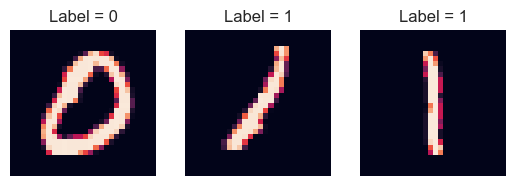

In [39]:
for data, target in digit_1_train_loader:
    data = data[0,:,:,:]
    plt.subplot(1,3,1)
    plt.imshow(data.permute(1,2,0))
    plt.title(f'Label = {target[0].item()}')
    plt.axis('off')
    break

for data, target in digit_2_train_loader:
    shape = data.shape
    data = data[0,:,:,:]
    plt.subplot(1,3,2)
    plt.imshow(data.permute(1,2,0))
    plt.title(f'Label = {target[0].item()}')
    plt.axis('off')
    break

for data, target in test_loader:
    shape = data.shape
    data = data[0,:,:,:]
    plt.subplot(1,3,3)
    plt.imshow(data.permute(1,2,0))
    plt.title(f'Label = {target[0].item()}')
    plt.axis('off')
    break

### Define agents and run consensus - FCNet

In [40]:
# delta = 0.4
deltas = [0, 0.1, 0.2, 0.4, 0.8, 100]
# deltas = [0, 0.4]
rho = 0.01
t_max = 100
loaders = [digit_1_train_loader_fc, digit_2_train_loader_fc]
device = 'cpu'

acc_per_delta = np.zeros((len(deltas), t_max))
rate_per_delta = np.zeros((len(deltas), t_max))
loads = []
test_accs = []

for i, delta in enumerate(deltas):
    
    agents = [
        FedConsensus(
            N=len(loaders),
            delta=delta,
            rho=rho,
            model=FCNet(in_channels=784, hidden1=200, hidden2=None, out_channels=2),
            loss=nn.CrossEntropyLoss(),
            train_loader=loader,
            classification=True,
            epochs=7,
            device=device
        ) for loader in loaders
    ]

    # Broadcast average to all agents and check if equal
    for agent in agents:
        agent.primal_avg = average_params([agent.model.parameters() for agent in agents])
    for param1, param2 in zip(agents[0].primal_avg, agents[1].primal_avg):
        if not torch.equal(param1, param2): raise ValueError("Averaged params aren't equal")

    # Run consensus algorithm
    server = EventADMM(clients=agents, t_max=t_max)
    server.spin(loader=val_loader_fc)
    
    # For plotting purposes
    acc_per_delta[i,:] = server.val_accs
    rate_per_delta[i,:] = server.rates
    loads.append(server.comm)
    accs = server.validate(loader=test_loader_fc)
    test_accs.append(sum(accs)/len(accs))


Comm frequency: 1.000, agent 0: 1.00, agent 1: 1.00: 100%|██████████| 100/100 [02:48<00:00,  1.69s/it]
Comm frequency: 1.000, agent 0: 1.00, agent 1: 1.00: 100%|██████████| 100/100 [02:56<00:00,  1.76s/it]
Comm frequency: 0.710, agent 0: 1.00, agent 1: 1.00: 100%|██████████| 100/100 [02:49<00:00,  1.69s/it]
Comm frequency: 0.060, agent 0: 0.99, agent 1: 1.00: 100%|██████████| 100/100 [02:48<00:00,  1.68s/it]
Comm frequency: 0.010, agent 0: 0.99, agent 1: 0.99: 100%|██████████| 100/100 [03:03<00:00,  1.84s/it]
Comm frequency: 0.000, agent 0: 0.61, agent 1: 0.53: 100%|██████████| 100/100 [02:47<00:00,  1.68s/it]


In [42]:
test_accs_fc = test_accs
loads_fc = loads
rates_per_delta_fc = rate_per_delta
acc_per_delta_fc = acc_per_delta
deltas_fc = deltas

### Plot effect of deltas

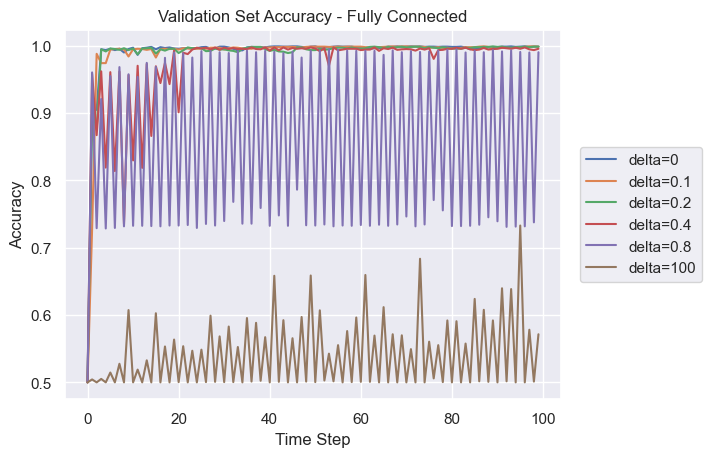

In [43]:
T = range(t_max)

# Plot accuracies
for acc, delta in zip(acc_per_delta_fc, deltas_fc):
    plt.plot(T, acc, label=f'delta={delta}')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Accuracy')
plt.title('Validation Set Accuracy - Fully Connected')
plt.show()

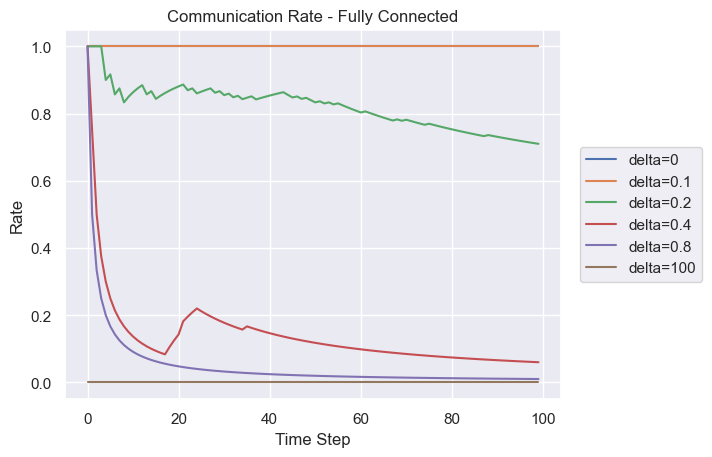

In [44]:
for rate, delta in zip(rates_per_delta_fc, deltas_fc):
    plt.plot(T, rate, label=f'delta={delta}')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Rate')
plt.title('Communication Rate - Fully Connected')
plt.show()

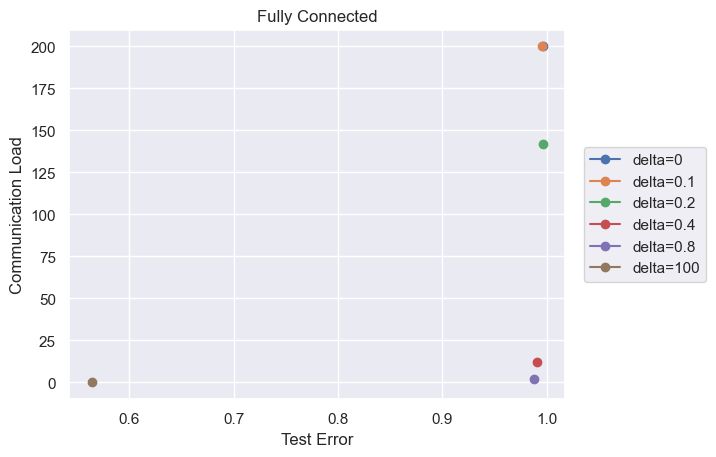

In [45]:
for load, acc, delta in zip(loads_fc, test_accs_fc, deltas_fc):
    plt.plot(acc, load, label=f'delta={delta}', marker='o')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Test Error')
plt.ylabel('Communication Load')
plt.title('Fully Connected')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(0.5,1)
# plt.ylim(0,100)
plt.show()

### Define agents and run consensus - CNN

In [50]:
# delta = 0.2
deltas = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 10]
# deltas = [0, 0.4]
rho = 0.01
t_max = 100
loaders = [digit_1_train_loader, digit_2_train_loader]
device = 'cpu'

acc_per_delta = np.zeros((len(deltas), t_max))
rate_per_delta = np.zeros((len(deltas), t_max))
loads = []
test_accs = []

for i, delta in enumerate(deltas):

    agents = [
        FedConsensus(
            N=len(loaders),
            delta=delta,
            rho=rho,
            model=CNN(),
            loss=nn.CrossEntropyLoss(),
            train_loader=loader,
            classification=True,
            epochs=7,
            device='cpu'
        ) for loader in loaders
    ]

    # Broadcast average to all agents and check if equal
    for agent in agents:
        agent.primal_avg = average_params([agent.model.parameters() for agent in agents])
    for param1, param2 in zip(agents[0].primal_avg, agents[1].primal_avg):
        if not torch.equal(param1, param2): raise ValueError("Averaged params aren't equal")

    # Run consensus algorithm
    server = EventADMM(clients=agents, t_max=t_max)
    server.spin(loader=val_loader)

    # For plotting purposes
    acc_per_delta[i,:] = server.val_accs
    rate_per_delta[i,:] = server.rates
    loads.append(server.comm)
    accs = server.validate(loader=test_loader)
    test_accs.append(sum(accs)/len(accs))


Comm frequency: 1.000, agent 0: 1.00, agent 1: 1.00: 100%|██████████| 100/100 [03:17<00:00,  1.97s/it]
Comm frequency: 0.290, agent 0: 0.99, agent 1: 0.99: 100%|██████████| 100/100 [03:18<00:00,  1.98s/it]
Comm frequency: 0.095, agent 0: 0.99, agent 1: 1.00: 100%|██████████| 100/100 [03:19<00:00,  1.99s/it]
Comm frequency: 0.540, agent 0: 0.97, agent 1: 0.98: 100%|██████████| 100/100 [03:18<00:00,  1.98s/it]
Comm frequency: 0.100, agent 0: 0.99, agent 1: 0.99: 100%|██████████| 100/100 [03:16<00:00,  1.97s/it]
Comm frequency: 0.080, agent 0: 1.00, agent 1: 0.99: 100%|██████████| 100/100 [03:12<00:00,  1.92s/it]
Comm frequency: 0.000, agent 0: 0.46, agent 1: 0.59: 100%|██████████| 100/100 [03:18<00:00,  1.99s/it]


### Plot effect of deltas

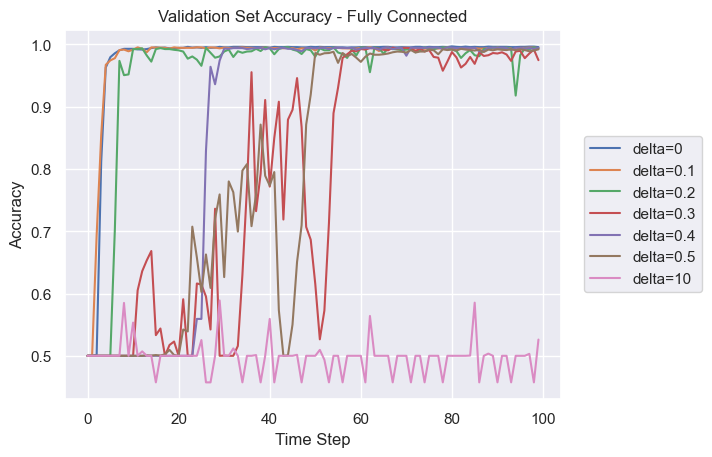

In [51]:
T = range(t_max)

# Plot accuracies
for acc, delta in zip(acc_per_delta, deltas):
    plt.plot(T, acc, label=f'delta={delta}')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Accuracy')
plt.title('Validation Set Accuracy - CNN')
plt.show()

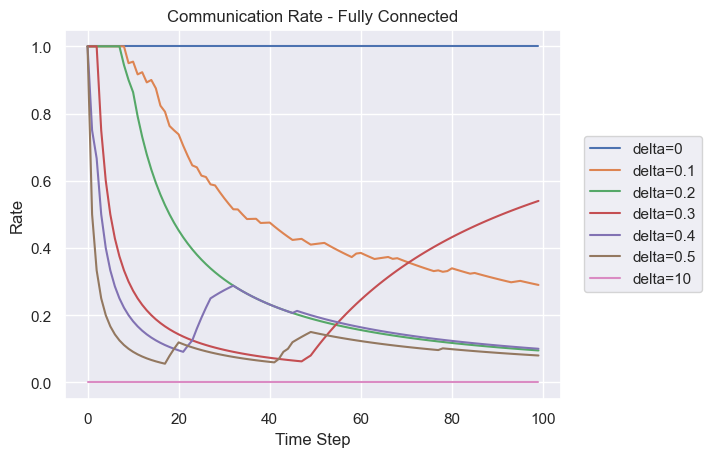

In [52]:
for rate, delta in zip(rate_per_delta, deltas):
    plt.plot(T, rate, label=f'delta={delta}')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Time Step')
plt.ylabel('Rate')
plt.title('Communication Rate - CNN')
plt.show()

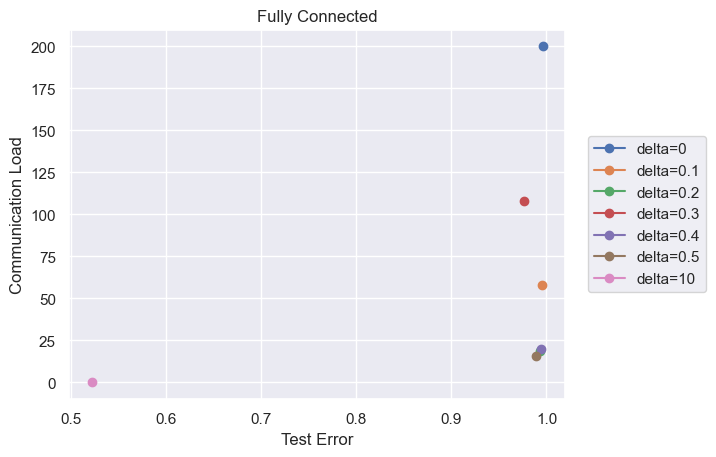

In [57]:
for load, acc, delta in zip(loads, test_accs, deltas):
    plt.plot(acc, load, label=f'delta={delta}', marker='o')
plt.legend(loc='center right', bbox_to_anchor=(1.3, 0.5))
plt.xlabel('Test Error')
plt.ylabel('Communication Load')
plt.title('CNN')
# plt.yscale('log')
# plt.xscale('log')
# plt.xlim(0.5,1)
# plt.ylim(0,100)
plt.show()